## Prerequisites

In [ ]:
# Install only the necessary libraries
!pip install -q transformers datasets evaluate huggingface_hub scikit-learn matplotlib seaborn torch pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Hugging Face login
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## RoBERTa Model

In [ ]:
# Step 2) Import Libraries

!pip install -q transformers datasets evaluate scikit-learn torch pandas

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Step 3) Load and prepare data

import json

# Path to your new JSON file
json_path = "/content/drive/MyDrive/bert_datasets/bert_TSclassification_data.json"

# Load JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
print("Data sample:")
print(df.head())

In [ ]:
# Step 4) Tokenize and Encode Labels (Single-label)

from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

# Load tokenizer
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Tokenize
tokenized = tokenizer(
    df["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt"
)
tokenized.pop("token_type_ids", None)

# Encode labels (single-label classification)
le = LabelEncoder()
y = le.fit_transform(df["label"])
num_labels = len(le.classes_)
print("Classes:", list(le.classes_))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Classes: ['["Access"]', '["Document change"]', '["Hardware - Application","Document change"]', '["Hardware - Application","Other"]', '["Hardware - Application"]', '["Hardware - Ipad"]', '["Hardware"]', '["Missing documents","Access"]', '["Missing documents","Document change"]', '["Missing documents"]', '["Other"]']


In [ ]:
# Step 5) Oversample rare classes & split

from collections import Counter

# Identify rare classes
label_counts = Counter(y)
rare_classes = [label for label, count in label_counts.items() if count < 20]

# Oversample rare classes
rare_df = df[[label in rare_classes for label in y]]
df_oversampled = pd.concat([df, rare_df], ignore_index=True)

# Re-tokenize and re-encode
tokenized = tokenizer(
    df_oversampled["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt"
)
tokenized.pop("token_type_ids", None)
y = le.transform(df_oversampled["label"])

# Train-validation split
train_idx, val_idx = train_test_split(range(len(df_oversampled)), test_size=0.2, random_state=42, stratify=y)
train_inputs = {k: v[train_idx] for k, v in tokenized.items()}
val_inputs = {k: v[val_idx] for k, v in tokenized.items()}
train_labels = torch.tensor(y[train_idx])
val_labels = torch.tensor(y[val_idx])


In [ ]:
# Step 6) Dataset Class (Single-Label)

class BertSingleLabelDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.inputs.items()}
        item["labels"] = self.labels[idx]
        return item

train_dataset = BertSingleLabelDataset(train_inputs, train_labels)
val_dataset = BertSingleLabelDataset(val_inputs, val_labels)

In [ ]:
# Step 7) Define Dataloaders

from torch.utils.data import DataLoader

# Define DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_dataset, batch_size=16, shuffle=False, pin_memory=torch.cuda.is_available()
)

In [ ]:
# Step 8) Model Definition (Single-Label, with crossentropy)

from transformers import AutoModel

class BertForSingleLabel(nn.Module):
    def __init__(self, model_name, num_labels, class_weights=None):
        super(BertForSingleLabel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token for sentence-level tasks
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits

        return logits

# Set the model checkpoint
model_ckpt = "roberta-base"

# Compute class weights (for imbalanced data)
class_sample_counts = np.bincount(y)
weights = torch.tensor(len(y) / (num_labels * class_sample_counts), dtype=torch.float).to(device)

# Instantiate the model
model = BertForSingleLabel(model_ckpt, num_labels=num_labels, class_weights=weights)
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSingleLabel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
# Step 9) Training Setup and Evaluation Functions (with Focal Loss — single-label)

from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
from tqdm import tqdm
import time

# Define Focal Loss Function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

# Set device again in case
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer and Focal Loss setup
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)
criterion = FocalLoss(alpha=1.0, gamma=2.0, weight=weights)

# Training Loop
def train_epoch():
    model.train()
    total_loss = 0
    start_time = time.time()

    loop = tqdm(train_loader, desc="Training", leave=False)
    for batch in loop:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    epoch_time = time.time() - start_time
    print(f"Train Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")
    return avg_loss

# Evaluation Loop
def evaluate():
    model.eval()
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            pred_labels = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(pred_labels)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average="weighted", zero_division=0)
    return acc, f1

In [ ]:
# Step 10) Train for N Epochs

num_epochs = 100
best_f1 = 0
history = {
    "epoch": [],
    "train_loss": [],
    "val_accuracy": [],
    "val_f1": []
}

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss = train_epoch()

    # Evaluate
    val_acc, val_f1 = evaluate()

    # Log metrics
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["val_accuracy"].append(val_acc)
    history["val_f1"].append(val_f1)

    # Print summary
    print(f"  Training Loss:         {train_loss:.4f}")
    print(f"  Validation Accuracy:   {val_acc:.4f}")
    print(f"  Validation F1 Score:   {val_f1:.4f}")
    print("-" * 40)

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")
        print("Best model saved!\n")

Epoch 1/100


Train Loss: 2.0107 | Time: 2.92s
  Training Loss:         2.0107
  Validation Accuracy:   0.0165
  Validation F1 Score:   0.0005
----------------------------------------
Best model saved!

Epoch 2/100


Train Loss: 1.9987 | Time: 2.49s
  Training Loss:         1.9987
  Validation Accuracy:   0.0331
  Validation F1 Score:   0.0273
----------------------------------------
Best model saved!

Epoch 3/100


Train Loss: 1.9431 | Time: 2.52s
  Training Loss:         1.9431
  Validation Accuracy:   0.1405
  Validation F1 Score:   0.0781
----------------------------------------
Best model saved!

Epoch 4/100


Train Loss: 1.8190 | Time: 2.50s
  Training Loss:         1.8190
  Validation Accuracy:   0.0579
  Validation F1 Score:   0.0442
----------------------------------------
Epoch 5/100


Train Loss: 1.6832 | Time: 2.50s
  Training Loss:         1.6832
  Validation Accuracy:   0.1818
  Validation F1 Score:   0.1078
----------------------------------------
Best model saved!

Epoch 6/100


Train Loss: 1.3520 | Time: 2.50s
  Training Loss:         1.3520
  Validation Accuracy:   0.2231
  Validation F1 Score:   0.1485
----------------------------------------
Best model saved!

Epoch 7/100


Train Loss: 1.1963 | Time: 2.48s
  Training Loss:         1.1963
  Validation Accuracy:   0.3058
  Validation F1 Score:   0.2448
----------------------------------------
Best model saved!

Epoch 8/100


Train Loss: 0.8242 | Time: 2.50s
  Training Loss:         0.8242
  Validation Accuracy:   0.2975
  Validation F1 Score:   0.2419
----------------------------------------
Epoch 9/100


Train Loss: 0.6452 | Time: 2.50s
  Training Loss:         0.6452
  Validation Accuracy:   0.3306
  Validation F1 Score:   0.2733
----------------------------------------
Best model saved!

Epoch 10/100


Train Loss: 0.6331 | Time: 2.53s
  Training Loss:         0.6331
  Validation Accuracy:   0.3554
  Validation F1 Score:   0.3083
----------------------------------------
Best model saved!

Epoch 11/100


Train Loss: 0.4474 | Time: 2.50s
  Training Loss:         0.4474
  Validation Accuracy:   0.3719
  Validation F1 Score:   0.3472
----------------------------------------
Best model saved!

Epoch 12/100


Train Loss: 0.3975 | Time: 2.54s
  Training Loss:         0.3975
  Validation Accuracy:   0.3967
  Validation F1 Score:   0.3610
----------------------------------------
Best model saved!

Epoch 13/100


Train Loss: 0.3539 | Time: 2.50s
  Training Loss:         0.3539
  Validation Accuracy:   0.3802
  Validation F1 Score:   0.3458
----------------------------------------
Epoch 14/100


Train Loss: 0.2686 | Time: 2.52s
  Training Loss:         0.2686
  Validation Accuracy:   0.3884
  Validation F1 Score:   0.3390
----------------------------------------
Epoch 15/100


Train Loss: 0.2429 | Time: 2.50s
  Training Loss:         0.2429
  Validation Accuracy:   0.4050
  Validation F1 Score:   0.3670
----------------------------------------
Best model saved!

Epoch 16/100


Train Loss: 0.2096 | Time: 2.48s
  Training Loss:         0.2096
  Validation Accuracy:   0.4215
  Validation F1 Score:   0.3977
----------------------------------------
Best model saved!

Epoch 17/100


Train Loss: 0.1754 | Time: 2.51s
  Training Loss:         0.1754
  Validation Accuracy:   0.4380
  Validation F1 Score:   0.4069
----------------------------------------
Best model saved!

Epoch 18/100


Train Loss: 0.1651 | Time: 2.48s
  Training Loss:         0.1651
  Validation Accuracy:   0.4876
  Validation F1 Score:   0.4727
----------------------------------------
Best model saved!

Epoch 19/100


Train Loss: 0.1626 | Time: 2.50s
  Training Loss:         0.1626
  Validation Accuracy:   0.5041
  Validation F1 Score:   0.4871
----------------------------------------
Best model saved!

Epoch 20/100


Train Loss: 0.1415 | Time: 2.51s
  Training Loss:         0.1415
  Validation Accuracy:   0.4545
  Validation F1 Score:   0.4254
----------------------------------------
Epoch 21/100


Train Loss: 0.1373 | Time: 2.52s
  Training Loss:         0.1373
  Validation Accuracy:   0.4628
  Validation F1 Score:   0.4422
----------------------------------------
Epoch 22/100


Train Loss: 0.1064 | Time: 2.51s
  Training Loss:         0.1064
  Validation Accuracy:   0.5207
  Validation F1 Score:   0.5092
----------------------------------------
Best model saved!

Epoch 23/100


Train Loss: 0.1019 | Time: 2.52s
  Training Loss:         0.1019
  Validation Accuracy:   0.5289
  Validation F1 Score:   0.5197
----------------------------------------
Best model saved!

Epoch 24/100


Train Loss: 0.0922 | Time: 2.51s
  Training Loss:         0.0922
  Validation Accuracy:   0.5372
  Validation F1 Score:   0.5304
----------------------------------------
Best model saved!

Epoch 25/100


Train Loss: 0.0868 | Time: 2.51s
  Training Loss:         0.0868
  Validation Accuracy:   0.5537
  Validation F1 Score:   0.5468
----------------------------------------
Best model saved!

Epoch 26/100


Train Loss: 0.0809 | Time: 2.51s
  Training Loss:         0.0809
  Validation Accuracy:   0.5041
  Validation F1 Score:   0.4929
----------------------------------------
Epoch 27/100


Train Loss: 0.0780 | Time: 2.50s
  Training Loss:         0.0780
  Validation Accuracy:   0.5455
  Validation F1 Score:   0.5381
----------------------------------------
Epoch 28/100


Train Loss: 0.0820 | Time: 2.53s
  Training Loss:         0.0820
  Validation Accuracy:   0.5207
  Validation F1 Score:   0.5078
----------------------------------------
Epoch 29/100


Train Loss: 0.0693 | Time: 2.53s
  Training Loss:         0.0693
  Validation Accuracy:   0.5372
  Validation F1 Score:   0.5250
----------------------------------------
Epoch 30/100


Train Loss: 0.0637 | Time: 2.50s
  Training Loss:         0.0637
  Validation Accuracy:   0.5537
  Validation F1 Score:   0.5494
----------------------------------------
Best model saved!

Epoch 31/100


Train Loss: 0.0574 | Time: 2.50s
  Training Loss:         0.0574
  Validation Accuracy:   0.5124
  Validation F1 Score:   0.5014
----------------------------------------
Epoch 32/100


Train Loss: 0.0656 | Time: 2.50s
  Training Loss:         0.0656
  Validation Accuracy:   0.5372
  Validation F1 Score:   0.5268
----------------------------------------
Epoch 33/100


Train Loss: 0.0580 | Time: 2.51s
  Training Loss:         0.0580
  Validation Accuracy:   0.5537
  Validation F1 Score:   0.5496
----------------------------------------
Best model saved!

Epoch 34/100


Train Loss: 0.0581 | Time: 2.50s
  Training Loss:         0.0581
  Validation Accuracy:   0.5289
  Validation F1 Score:   0.5256
----------------------------------------
Epoch 35/100


Train Loss: 0.0597 | Time: 2.51s
  Training Loss:         0.0597
  Validation Accuracy:   0.5289
  Validation F1 Score:   0.5175
----------------------------------------
Epoch 36/100


Train Loss: 0.0565 | Time: 2.51s
  Training Loss:         0.0565
  Validation Accuracy:   0.5785
  Validation F1 Score:   0.5774
----------------------------------------
Best model saved!

Epoch 37/100


Train Loss: 0.0562 | Time: 2.52s
  Training Loss:         0.0562
  Validation Accuracy:   0.5785
  Validation F1 Score:   0.5758
----------------------------------------
Epoch 38/100


Train Loss: 0.0495 | Time: 2.52s
  Training Loss:         0.0495
  Validation Accuracy:   0.5455
  Validation F1 Score:   0.5483
----------------------------------------
Epoch 39/100


Train Loss: 0.0439 | Time: 2.50s
  Training Loss:         0.0439
  Validation Accuracy:   0.5455
  Validation F1 Score:   0.5483
----------------------------------------
Epoch 40/100


Train Loss: 0.0552 | Time: 2.51s
  Training Loss:         0.0552
  Validation Accuracy:   0.5785
  Validation F1 Score:   0.5810
----------------------------------------
Best model saved!

Epoch 41/100


Train Loss: 0.0449 | Time: 2.51s
  Training Loss:         0.0449
  Validation Accuracy:   0.5372
  Validation F1 Score:   0.5319
----------------------------------------
Epoch 42/100


Train Loss: 0.0416 | Time: 2.53s
  Training Loss:         0.0416
  Validation Accuracy:   0.5785
  Validation F1 Score:   0.5770
----------------------------------------
Epoch 43/100


Train Loss: 0.0390 | Time: 2.51s
  Training Loss:         0.0390
  Validation Accuracy:   0.5537
  Validation F1 Score:   0.5564
----------------------------------------
Epoch 44/100


Train Loss: 0.0430 | Time: 2.51s
  Training Loss:         0.0430
  Validation Accuracy:   0.5455
  Validation F1 Score:   0.5411
----------------------------------------
Epoch 45/100


Train Loss: 0.0365 | Time: 2.52s
  Training Loss:         0.0365
  Validation Accuracy:   0.6033
  Validation F1 Score:   0.6072
----------------------------------------
Best model saved!

Epoch 46/100


Train Loss: 0.0364 | Time: 2.52s
  Training Loss:         0.0364
  Validation Accuracy:   0.5702
  Validation F1 Score:   0.5725
----------------------------------------
Epoch 47/100


Train Loss: 0.0347 | Time: 2.52s
  Training Loss:         0.0347
  Validation Accuracy:   0.5785
  Validation F1 Score:   0.5799
----------------------------------------
Epoch 48/100


Train Loss: 0.0371 | Time: 2.51s
  Training Loss:         0.0371
  Validation Accuracy:   0.5455
  Validation F1 Score:   0.5357
----------------------------------------
Epoch 49/100


Train Loss: 0.0365 | Time: 2.52s
  Training Loss:         0.0365
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5969
----------------------------------------
Epoch 50/100


Train Loss: 0.0320 | Time: 2.54s
  Training Loss:         0.0320
  Validation Accuracy:   0.5702
  Validation F1 Score:   0.5709
----------------------------------------
Epoch 51/100


Train Loss: 0.0283 | Time: 2.53s
  Training Loss:         0.0283
  Validation Accuracy:   0.6198
  Validation F1 Score:   0.6261
----------------------------------------
Best model saved!

Epoch 52/100


Train Loss: 0.0284 | Time: 2.53s
  Training Loss:         0.0284
  Validation Accuracy:   0.6033
  Validation F1 Score:   0.6096
----------------------------------------
Epoch 53/100


Train Loss: 0.0284 | Time: 2.53s
  Training Loss:         0.0284
  Validation Accuracy:   0.6116
  Validation F1 Score:   0.6168
----------------------------------------
Epoch 54/100


Train Loss: 0.0293 | Time: 2.53s
  Training Loss:         0.0293
  Validation Accuracy:   0.5785
  Validation F1 Score:   0.5894
----------------------------------------
Epoch 55/100


Train Loss: 0.0354 | Time: 2.52s
  Training Loss:         0.0354
  Validation Accuracy:   0.5537
  Validation F1 Score:   0.5473
----------------------------------------
Epoch 56/100


Train Loss: 0.0287 | Time: 2.50s
  Training Loss:         0.0287
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5923
----------------------------------------
Epoch 57/100


Train Loss: 0.0254 | Time: 2.52s
  Training Loss:         0.0254
  Validation Accuracy:   0.5702
  Validation F1 Score:   0.5759
----------------------------------------
Epoch 58/100


Train Loss: 0.0259 | Time: 2.53s
  Training Loss:         0.0259
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.6005
----------------------------------------
Epoch 59/100


Train Loss: 0.0250 | Time: 2.54s
  Training Loss:         0.0250
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.6042
----------------------------------------
Epoch 60/100


Train Loss: 0.0283 | Time: 2.54s
  Training Loss:         0.0283
  Validation Accuracy:   0.5702
  Validation F1 Score:   0.5702
----------------------------------------
Epoch 61/100


Train Loss: 0.0217 | Time: 2.53s
  Training Loss:         0.0217
  Validation Accuracy:   0.6116
  Validation F1 Score:   0.6146
----------------------------------------
Epoch 62/100


Train Loss: 0.0252 | Time: 2.51s
  Training Loss:         0.0252
  Validation Accuracy:   0.6033
  Validation F1 Score:   0.6122
----------------------------------------
Epoch 63/100


Train Loss: 0.0194 | Time: 2.52s
  Training Loss:         0.0194
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5858
----------------------------------------
Epoch 64/100


Train Loss: 0.0213 | Time: 2.53s
  Training Loss:         0.0213
  Validation Accuracy:   0.6281
  Validation F1 Score:   0.6378
----------------------------------------
Best model saved!

Epoch 65/100


Train Loss: 0.0195 | Time: 2.52s
  Training Loss:         0.0195
  Validation Accuracy:   0.6281
  Validation F1 Score:   0.6378
----------------------------------------
Epoch 66/100


Train Loss: 0.0212 | Time: 2.52s
  Training Loss:         0.0212
  Validation Accuracy:   0.6116
  Validation F1 Score:   0.6126
----------------------------------------
Epoch 67/100


Train Loss: 0.0160 | Time: 2.52s
  Training Loss:         0.0160
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5894
----------------------------------------
Epoch 68/100


Train Loss: 0.0186 | Time: 2.54s
  Training Loss:         0.0186
  Validation Accuracy:   0.5372
  Validation F1 Score:   0.5340
----------------------------------------
Epoch 69/100


Train Loss: 0.0218 | Time: 2.52s
  Training Loss:         0.0218
  Validation Accuracy:   0.6116
  Validation F1 Score:   0.6238
----------------------------------------
Epoch 70/100


Train Loss: 0.0181 | Time: 2.53s
  Training Loss:         0.0181
  Validation Accuracy:   0.6281
  Validation F1 Score:   0.6377
----------------------------------------
Epoch 71/100


Train Loss: 0.0182 | Time: 2.53s
  Training Loss:         0.0182
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.6071
----------------------------------------
Epoch 72/100


Train Loss: 0.0188 | Time: 2.53s
  Training Loss:         0.0188
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.6026
----------------------------------------
Epoch 73/100


Train Loss: 0.0184 | Time: 2.51s
  Training Loss:         0.0184
  Validation Accuracy:   0.6116
  Validation F1 Score:   0.6190
----------------------------------------
Epoch 74/100


Train Loss: 0.0158 | Time: 2.50s
  Training Loss:         0.0158
  Validation Accuracy:   0.6198
  Validation F1 Score:   0.6272
----------------------------------------
Epoch 75/100


Train Loss: 0.0142 | Time: 2.52s
  Training Loss:         0.0142
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.5982
----------------------------------------
Epoch 76/100


Train Loss: 0.0157 | Time: 2.52s
  Training Loss:         0.0157
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5959
----------------------------------------
Epoch 77/100


Train Loss: 0.0145 | Time: 2.53s
  Training Loss:         0.0145
  Validation Accuracy:   0.6198
  Validation F1 Score:   0.6258
----------------------------------------
Epoch 78/100


Train Loss: 0.0178 | Time: 2.52s
  Training Loss:         0.0178
  Validation Accuracy:   0.6033
  Validation F1 Score:   0.6125
----------------------------------------
Epoch 79/100


Train Loss: 0.0314 | Time: 2.51s
  Training Loss:         0.0314
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5958
----------------------------------------
Epoch 80/100


Train Loss: 0.0840 | Time: 2.51s
  Training Loss:         0.0840
  Validation Accuracy:   0.5455
  Validation F1 Score:   0.5447
----------------------------------------
Epoch 81/100


Train Loss: 0.0399 | Time: 2.53s
  Training Loss:         0.0399
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.6090
----------------------------------------
Epoch 82/100


Train Loss: 0.0391 | Time: 2.55s
  Training Loss:         0.0391
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5924
----------------------------------------
Epoch 83/100


Train Loss: 0.0207 | Time: 2.51s
  Training Loss:         0.0207
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5919
----------------------------------------
Epoch 84/100


Train Loss: 0.0188 | Time: 2.53s
  Training Loss:         0.0188
  Validation Accuracy:   0.6033
  Validation F1 Score:   0.6068
----------------------------------------
Epoch 85/100


Train Loss: 0.0130 | Time: 2.52s
  Training Loss:         0.0130
  Validation Accuracy:   0.6116
  Validation F1 Score:   0.6118
----------------------------------------
Epoch 86/100


Train Loss: 0.0140 | Time: 2.51s
  Training Loss:         0.0140
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.5994
----------------------------------------
Epoch 87/100


Train Loss: 0.0117 | Time: 2.53s
  Training Loss:         0.0117
  Validation Accuracy:   0.6198
  Validation F1 Score:   0.6226
----------------------------------------
Epoch 88/100


Train Loss: 0.0123 | Time: 2.52s
  Training Loss:         0.0123
  Validation Accuracy:   0.6198
  Validation F1 Score:   0.6266
----------------------------------------
Epoch 89/100


Train Loss: 0.0198 | Time: 2.53s
  Training Loss:         0.0198
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.5946
----------------------------------------
Epoch 90/100


Train Loss: 0.0119 | Time: 2.51s
  Training Loss:         0.0119
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5876
----------------------------------------
Epoch 91/100


Train Loss: 0.0120 | Time: 2.54s
  Training Loss:         0.0120
  Validation Accuracy:   0.5620
  Validation F1 Score:   0.5674
----------------------------------------
Epoch 92/100


Train Loss: 0.0092 | Time: 2.53s
  Training Loss:         0.0092
  Validation Accuracy:   0.6033
  Validation F1 Score:   0.6134
----------------------------------------
Epoch 93/100


Train Loss: 0.0127 | Time: 2.52s
  Training Loss:         0.0127
  Validation Accuracy:   0.5868
  Validation F1 Score:   0.5932
----------------------------------------
Epoch 94/100


Train Loss: 0.0118 | Time: 2.53s
  Training Loss:         0.0118
  Validation Accuracy:   0.6116
  Validation F1 Score:   0.6201
----------------------------------------
Epoch 95/100


Train Loss: 0.0094 | Time: 2.53s
  Training Loss:         0.0094
  Validation Accuracy:   0.6033
  Validation F1 Score:   0.6082
----------------------------------------
Epoch 96/100


Train Loss: 0.0091 | Time: 2.53s
  Training Loss:         0.0091
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.5986
----------------------------------------
Epoch 97/100


Train Loss: 0.0099 | Time: 2.52s
  Training Loss:         0.0099
  Validation Accuracy:   0.5785
  Validation F1 Score:   0.5796
----------------------------------------
Epoch 98/100


Train Loss: 0.0118 | Time: 2.53s
  Training Loss:         0.0118
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.6065
----------------------------------------
Epoch 99/100


Train Loss: 0.0161 | Time: 2.51s
  Training Loss:         0.0161
  Validation Accuracy:   0.6033
  Validation F1 Score:   0.6065
----------------------------------------
Epoch 100/100


Train Loss: 0.0104 | Time: 2.53s
  Training Loss:         0.0104
  Validation Accuracy:   0.5950
  Validation F1 Score:   0.5976
----------------------------------------


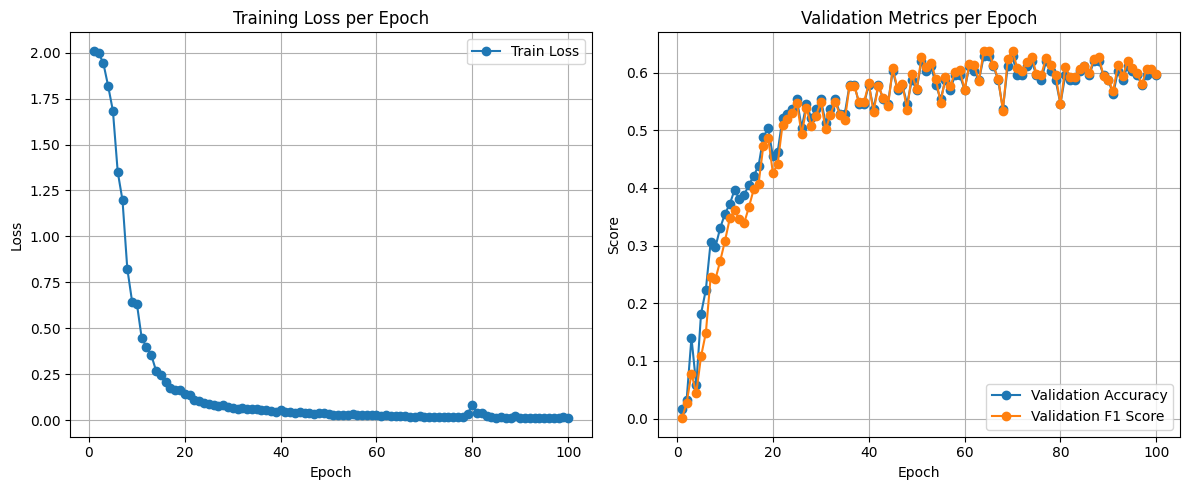

In [ ]:
# Step 11) Plot performance

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss", marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["val_accuracy"], label="Validation Accuracy", marker='o')
plt.plot(history["epoch"], history["val_f1"], label="Validation F1 Score", marker='o')
plt.title("Validation Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Save model

# Create a path in your Drive, e.g., in a "bert_models" folder
save_path = "/content/drive/MyDrive/bert_models/Roberta_TS1.pt"
torch.save(model.state_dict(), save_path)
print("Best model saved to Google Drive!")

Best model saved to Google Drive!
